
## Tuyere model for PDF shaping (894 samples)

This uses the new object oriented class for PDF shaping.

This model uses the CFD tuyere data with 894 samples

## Web application 5 inputs and 2 outputs

Run interactively on the web at:

## Inputs


(2, 'i_pul_coal_inj_kg_thm')

(3, 'i_nat_gas_inj_kg_thm')

(4, 'i_nat_gas_t_k')

(5, 'i_o2_vol_perce')

(9, 'i_hot_blast_temp_k')

## Outputs

(14, 'o_tuyere_exit_velo_m_s')

(15, 'o_tuyere_t_k')


In [1]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [2]:
import PDFshapingUtils as PDF_tk

In [3]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()


In [4]:

PDFshapingOBJ.initializeImpulseGaussian()

print(PDFshapingOBJ.x_range_impulse_func )
print(PDFshapingOBJ.impulse_func_vector_vals )
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([4000])
torch.Size([4000])
tensor(100.0000)


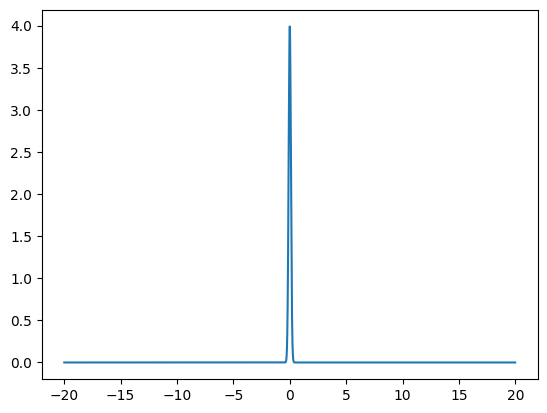

In [5]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()


## RUN KDE test

In [6]:
## PDFshapingOBJ.test_torchKDE_with_fake_data()

## Load Data

In [7]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.11.2023.csv')


In [8]:

PDFshapingOBJ.CFD_raw_data


,index,i_h2_inj_kg_thm,i_pul_coal_inj_kg_thm,i_nat_gas_inj_kg_thm,i_nat_gas_t_k,i_o2_vol_perce,i_bf_windrate_nm3_hr,i_hb_moist_g_nm3,i_hot_blast_press_pa,i_hot_blast_temp_k,...,o_shaft_co_utiliz,o_shaft_h2_utiliz,o_shaft_top_gas_temp_c,o_shaft_press_drop_pa,o_shaft_coke_rate_kg_thm,o_shaft_cohesive_zone_tip_height_m,o_shaft_co_v_perc,o_shaft_co2_v_perc,o_shaft_h2_v_perce,o_shaft_n2_v_perc
0,1,0,0,37.9,300,21,308750.365,12.154,359906.3,1459.817,...,47.20085,42.99392,118.8785,108434.33,462.73655,31.83963,0.217192,0.194163,0.043833,0.544812
1,2,0,0,37.9,300,24,308750.365,12.154,359906.3,1459.817,...,49.15851,44.99764,95.7563,108381.02,480.82105,31.83963,0.226098,0.218613,0.040343,0.514946
2,3,0,0,37.9,300,27,308750.365,12.154,359906.3,1459.817,...,49.30602,44.48147,84.8519,112232.83,500.10050,31.75963,0.241959,0.235334,0.037726,0.484981
3,4,0,0,37.9,300,30,308750.365,12.154,359906.3,1459.817,...,47.22992,46.37194,66.3779,118634.40,521.58650,31.55962,0.267702,0.239597,0.035448,0.457252
4,5,0,0,70.0,300,21,308750.365,12.154,359906.3,1459.817,...,46.66340,41.83302,130.4139,106947.64,422.57185,31.75963,0.211014,0.184613,0.071127,0.533246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,890,20,0,70.0,300,27,308750.365,12.154,359906.3,1459.817,...,48.11546,42.78430,122.0079,137423.80,421.58995,31.80024,0.213421,0.197917,0.122270,0.466392
890,891,30,0,60.0,300,27,308750.365,12.154,359906.3,1459.817,...,47.40511,41.99833,132.4238,146622.00,419.73570,31.88024,0.209051,0.188423,0.143751,0.458775
891,892,10,0,100.0,300,27,308750.365,12.154,359906.3,1459.817,...,48.24004,41.11932,121.1668,128838.00,409.45505,31.80024,0.216270,0.201562,0.117991,0.464177
892,893,20,0,90.0,300,27,308750.365,12.154,359906.3,1459.817,...,47.21544,39.43614,129.2255,129115.30,410.35835,31.76024,0.213118,0.190633,0.142068,0.454181


In [11]:

PDFshapingOBJ.print_headers_list()


['index', 'i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
30
(0, 'index')
(1, 'i_h2_inj_kg_thm')
(2, 'i_pul_coal_inj_kg_thm')
(3, 'i_nat_gas_inj_kg_thm')
(4, 'i_nat_gas_t_k')
(5, 'i_o2_vol_perce')
(6, 'i_bf_windrate_nm3_hr')
(7, 'i_hb_moist_g_nm3')
(8, 'i_hot_blast_press_pa')
(9, 'i_hot_blast_temp_k')
(10, 'i_ore_moisture_weight_perce')
(11, 'i_coke_weight_kg')
(12, 

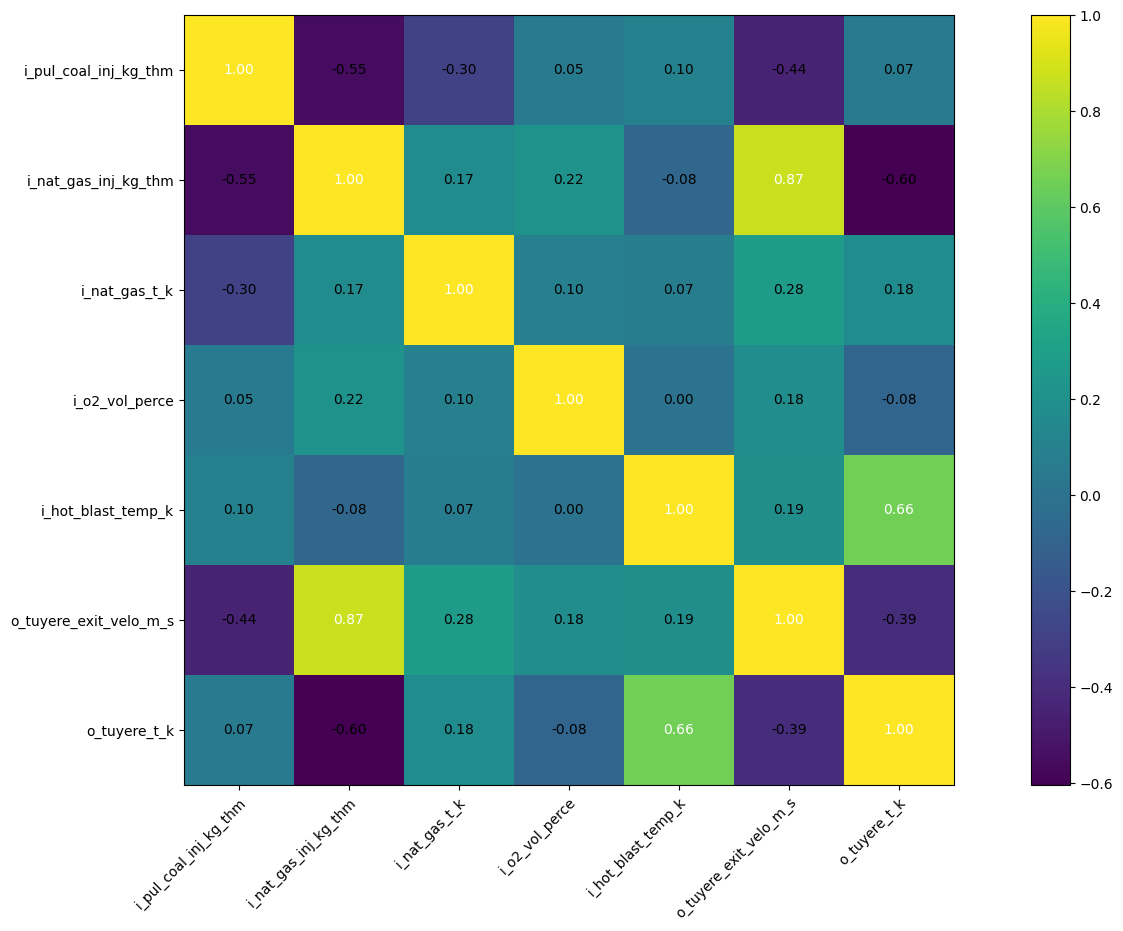

In [13]:

PDFshapingOBJ.list_of_selected_column_names = [ 'i_pul_coal_inj_kg_thm', 
                'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k',
                'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k']

PDFshapingOBJ.print_correlation_coefficients()


In [14]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  1.           0.           0.         ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.           0.         ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.           0.         ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [892.          10.           0.         ...   0.2015624    0.1179911
    0.4641767 ]
 [893.          20.           0.         ...   0.1906331    0.1420678
    0.4541806 ]
 [894.          30.           0.         ...   0.1820335    0.1569839
    0.4515486 ]]
(894, 30)



## Select inputs and outputs


In [15]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs=[ 2, 3, 4, 5, 9], 
                   outputs=[14, 15]   
)


5
2


In [16]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(894, 5)
(894, 2)


In [17]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [18]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(715, 5)
(179, 5)
(715, 2)
(179, 2)


In [19]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [20]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [21]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


## NN architectures

In [22]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 2) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      


In [23]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(5, 2)       
        
        ## F2
        self.f2_linear1 = nn.Linear(5, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 2)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [24]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    


In [25]:

PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"


0  loss=  tensor(1.0539, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.0931, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0516, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0229, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0146, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.0193, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0243, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0304, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0181, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0168, grad_fn=<MseLossBackward0>)


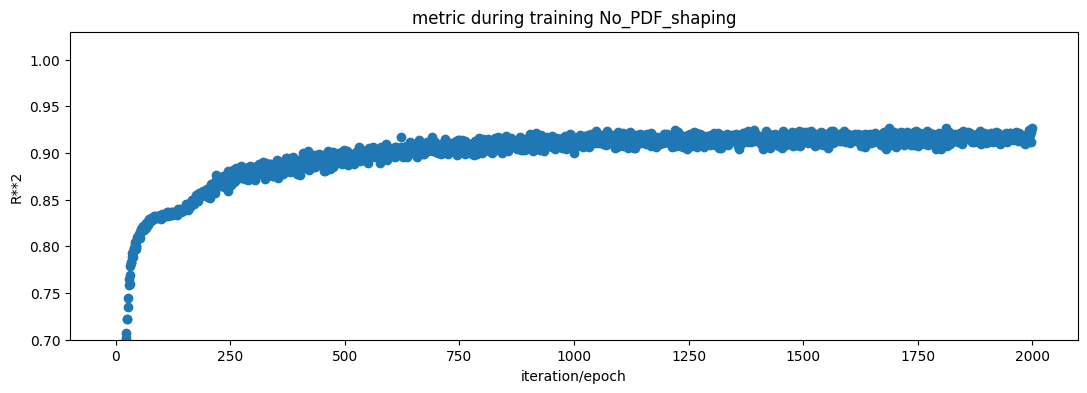

Training loss: tensor(0.0735, grad_fn=<MseLossBackward0>)
Training R**2: 0.9206241718718831
Test loss - scaled: tensor(0.0396, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(17.3800, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9627551332249324
Testing R**2 - descaled: 0.9627551367422738
*****
*****
Testing R**2 - Output: 0 o_tuyere_exit_velo_m_s 0.9570295313854643
*****
*****
Testing R**2 - Output: 1 o_tuyere_t_k 0.9684807421684911


In [26]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [ ]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


In [ ]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [ ]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
      
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    ## opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
       
        
        error     = pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()        ## 894  x 6
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )             ## 4000 x 6
        
        diff = ( basisFunc.float() - PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() )  ## 4000 x 6

        
        loss = torch.mean(   (   diff  )**2    )  
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        

        print(epoch, " loss= ", loss)
        if epoch % 50 == 0:
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    




In [ ]:

PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

PDFshapingOBJ.N_EPOCHS             = 2000
PDFshapingOBJ.N_EPOCHS_PDF         = 2000


In [ ]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)



opt         = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )

loss_fn     = F.mse_loss


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [ ]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


In [ ]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## Export ONNX model


In [ ]:

'''

model.eval()

dummy_input = torch.randn(1, 4)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''
